# Some utilities

In [1]:
def analyze_general_info(df):
    # Check the shape of the DataFrame (rows, columns)
    print('\nShape of the DataFrame:\n', df.shape)
    
    analysis = []
    for col in df.columns:
        # Check dtypes
        dtype = df[col].dtype
        # Count NaN values
        num_nan = df[col].isna().sum()
        analysis.append([col, dtype, num_nan])

    df_analysis = pd.DataFrame(analysis, columns=['Column', 'Dtype', 'NumOfNaN'])
    df_analysis.index = [''] * len(df_analysis)  # Set index to empty strings
    display(df_analysis.T)  # transpose the DataFrame before displaying

def analyze_on_RID(df):
    
    print(f"There are in total {len(df['RID'].unique())} unique RIDs.")
    
    # Check dependency
    dependency_check = []
    for column in df.columns:
        is_dependent = df_all.groupby('RID')[column].nunique().max() == 1
        dependency_check.append([column, is_dependent])
        
    df_dependency = pd.DataFrame(dependency_check, columns=['Column', 'IsDependentOnRID'])
    df_dependency.index = [''] * len(df_dependency)  # Set index to empty strings
    display(df_dependency.T)  # transpose the DataFrame before displaying

def analyze_simple_visual(df):
    # Visualizing the distribution of numeric variables
    df.hist(bins=50, figsize=(20,15))
    plt.show()

    # Plotting correlation matrix to understand the relationship between variables
    plt.figure(figsize=(15,15))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.show()
    
def remove_outliers(df, col, lower_percent=5, upper_percent=95):
    lower = df[col].quantile(lower_percent*0.01)
    upper = df[col].quantile(upper_percent*0.01)

    # Create a mask for values within the desired range
    mask = (df[col] >= lower) & (df[col] <= upper)

    # Return a new DataFrame that only includes rows where the column value is within the desired range
    return df[mask]

def scatter_plot(df, col1, col2, col3=None):
    if col3 is None:
        plt.scatter(df[col1], df[col2])
        plt.title(f'Scatter plot of {col1} vs {col2}')
    else:
        plt.scatter(df[col1], df[col2], c=df[col3], cmap='coolwarm')
        plt.title(f'Scatter plot of {col1} vs {col2} colored by {col3}')
        plt.colorbar(label=col3)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()
    
def scatter_plot_by_category(df, col1, col2, category_col, col3=None):
    df = remove_outliers(df,col1,5)
    df = remove_outliers(df,col2,5)
    categories = df[category_col].unique()
    
    for category in categories:
        df_subset = df[df[category_col] == category]
        
        if col3 is None:
            plt.scatter(df_subset[col1], df_subset[col2])
            plt.title(f'Scatter plot of {col1} vs {col2} for {category_col} = {category}')
        else:
            plt.scatter(df_subset[col1], df_subset[col2], c=df_subset[col3], cmap='coolwarm')
            plt.title(f'Scatter plot of {col1} vs {col2} colored by {col3} for {category_col} = {category}')
            plt.colorbar(label=col3)
            
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()

    
def plot_ad_ratio(df, col1):
    df = remove_outliers(df, col1, 5).copy()
    
    # Create a new column 'bins' in the DataFrame that indicates which bin each row falls into
    df['bins'] = pd.cut(df[col1], bins=10)
    
    # Group the DataFrame by the 'bins' column and calculate the ratio of "AD" in "DX_bl" for each group
    ad_ratios = df.groupby('bins')['DX_bl'].apply(lambda x: (x == 1).mean())

    # Create the plot
    plt.plot(ad_ratios.index.astype(str), ad_ratios, marker='o')
    plt.xlabel(col1)
    plt.ylabel('Ratio of AD')
    plt.title(f'Ratio of AD in DX_bl for each bin of {col1}')
    plt.xticks(rotation=45)
    plt.show()
    
    # Remove the 'bins' column
    df.drop('bins', axis=1, inplace=True)
    
def plot_ave_in_bins(df, col1, col2):
    df = remove_outliers(df, col1, 5).copy()
    df = remove_outliers(df, col2, 5).copy()
    
    # Create bins based on col1 values
    df['bins'] = pd.cut(df[col1], bins=20)
    
    # Group by the bins and calculate average of col2 values in each bin
    averages = df.groupby('bins')[col2].mean()
    
    # Plot the averages
    plt.figure(figsize=(10, 6))
    plt.plot(averages.index.astype(str), averages.values, marker='o')
    plt.xlabel(col1)
    plt.ylabel('Average of ' + col2)
    plt.title('Average of ' + col2 + ' in bins of ' + col1)
    plt.xticks(rotation=45)
    plt.show()

    # Remove the 'bins' column
    df.drop('bins', axis=1, inplace=True)


# Load and clean data

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthBegin
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.io import write_html, write_image
from datetime import timedelta
from datetime import datetime
import imageio
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from IPython.display import display

In [3]:
# Read data file
df_all = pd.read_csv('ADNI-compact-dataset-2023-0601-orig.csv')

# Convert 'EXAMDATE' to datetime format
df_all['EXAMDATE'] = pd.to_datetime(df_all['EXAMDATE'])

# Sort by 'RID' and 'EXAMDATE'
df_all = df_all.sort_values(['RID', 'EXAMDATE'])

# Replace the 'AGE' column in the original DataFrame with calculated age
df_bl = df_all[df_all['VISCODE'] == 'bl'][['RID', 'EXAMDATE', 'AGE']].rename(columns={'EXAMDATE': 'EXAMDATE_bl', 'AGE': 'AGE_bl'})
df_all = pd.merge(df_all, df_bl, on='RID', how='left')
df_all['AGE_DIFF'] = (df_all['EXAMDATE'] - df_all['EXAMDATE_bl']).dt.days / 365.25
df_all['AGE_NEW'] = df_all['AGE_bl'] + df_all['AGE_DIFF']
df_all['AGE'] = df_all['AGE_NEW'].round(1)
df_all = df_all.drop(columns=['EXAMDATE_bl', 'AGE_bl', 'AGE_DIFF', 'AGE_NEW'])

# Drop the unuseful cloumn
df_all.drop(columns=['Unnamed: 12', 'VISCODE', 'PTETHCAT', 'PTRACCAT', 'PTMARRY'], inplace=True)

# Drop rows with missing values in DX_bl
df_all = df_all.dropna(subset=['DX_bl'])

# Fill some missing values with NA - not applicable
# df_all.fillna({'DX_bl': 'NA', 'PTMARRY': 'NA'}, inplace=True)

# Change categorical values to numerical
df_all['PTGENDER'] = df_all['PTGENDER'].map({'Female': 0, 'Male': 1})
# df_all['APOE4'] = df_all['APOE4'].astype(int)
# df_all['PTEDUCAT'] = df_all['PTEDUCAT'].astype(float)

# Replace the text noted outliers and make sure ABETA values are numeric
# df_all['ABETA'] = df_all['ABETA'].replace({
#     '<200': 100,
#     '>1700': 2000
# })
df_all['ABETA'] = df_all['ABETA'].replace({
    '<200': np.nan,
    '>1700': np.nan
})
df_all['ABETA'] = df_all['ABETA'].astype(float)

# Replace the text noted outliers and make sure TAU values are numeric
# df_all['TAU'] = df_all['TAU'].replace({
#     '<80': 50,
#     '>1300': 150
# })
df_all['TAU'] = df_all['TAU'].replace({
    '<80': np.nan,
    '>1300': np.nan
})
df_all['TAU'] = df_all['TAU'].astype(float)

# Replace the text noted outliers and make sure PTAU values are numeric
# df_all['PTAU'] = df_all['PTAU'].replace({
#     '<8': 0,
#     '>120': 150
# })
df_all['PTAU'] = df_all['PTAU'].replace({
    '<8': np.nan,
    '>120': np.nan
})
df_all['PTAU'] = df_all['PTAU'].astype(float)

# Set the value of PET to 0 if it is negative
df_all.loc[df_all['PET-CL'] < 0, 'PET-CL'] = 0

# Save the cleaned data as .csv file
df_all.to_csv('temp_clean.csv', index=False)

In [4]:
analyze_general_info(df_all)


Shape of the DataFrame:
 (16334, 17)


,,,,,,,,,,,,,,,,,
Column,RID,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,APOE4,FDG,PET-CL,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE
Dtype,int64,datetime64[ns],object,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NumOfNaN,0,0,0,9,0,0,336,12643,12745,14316,13973,13977,4641,4949,5050,4914,4916


In [5]:
# Calculate the "average" rate of change of cognitive scores
roc_column_names = ['RID'] + [f'{col}_roc' for col in df_all.columns[-10:]]
df_roc = pd.DataFrame(columns=roc_column_names)

# All unique RIDs
unique_rids = df_all['RID'].unique()

# For each RID, calculate the rate of change for each of the last 10 columns
for rid in unique_rids:
    df_rid = df_all[df_all['RID'] == rid].sort_values('EXAMDATE')

    # Convert EXAMDATE to the number of days from the earliest date
    df_rid['EXAMDATE'] = (df_rid['EXAMDATE'] - df_rid['EXAMDATE'].min()).dt.days / 180

    # Initialize a dictionary to hold the rate of change for each column
    roc_dict = {'RID': rid}

    for col in df_all.columns[-10:]:
        # Check if the DataFrame has less than two rows for the current column
        if len(df_rid[df_rid[col].notnull()]) < 2:
            roc_dict[f'{col}_roc'] = np.nan
            continue

        # # Drop rows with NaN
        df_rid_col = df_rid.dropna(subset=[col])

        # Linear regression
        X = df_rid_col['EXAMDATE'].values.reshape(-1, 1)  # Features
        y = df_rid_col[col].values  # Target

        model = LinearRegression()
        model.fit(X, y)

        # Get the slope (rate of change)
        roc_dict[f'{col}_roc'] = model.coef_[0]

    # Save the rates of change in df_roc
    df_roc = pd.concat([df_roc, pd.DataFrame([roc_dict])], ignore_index=True)

# Reset index of df_roc
df_roc.reset_index(drop=True, inplace=True)
# df_roc['RID'] = df_all['RID'].astype(int)

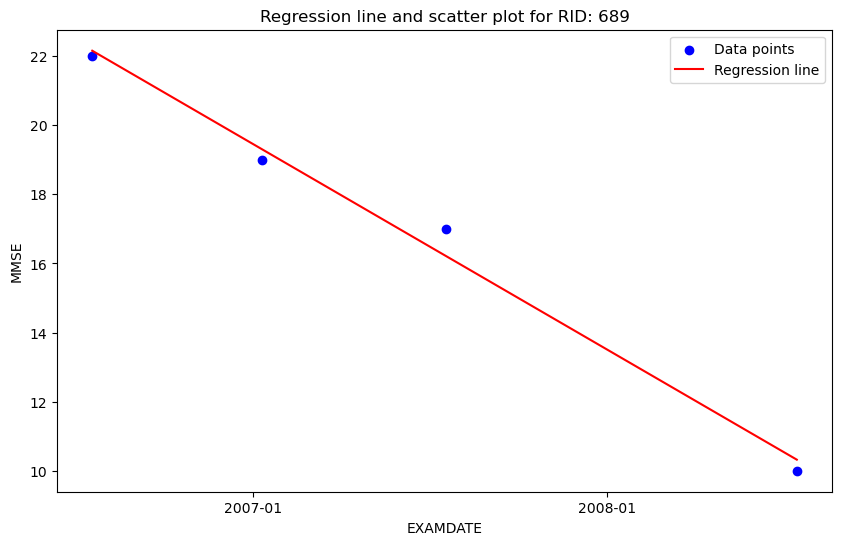

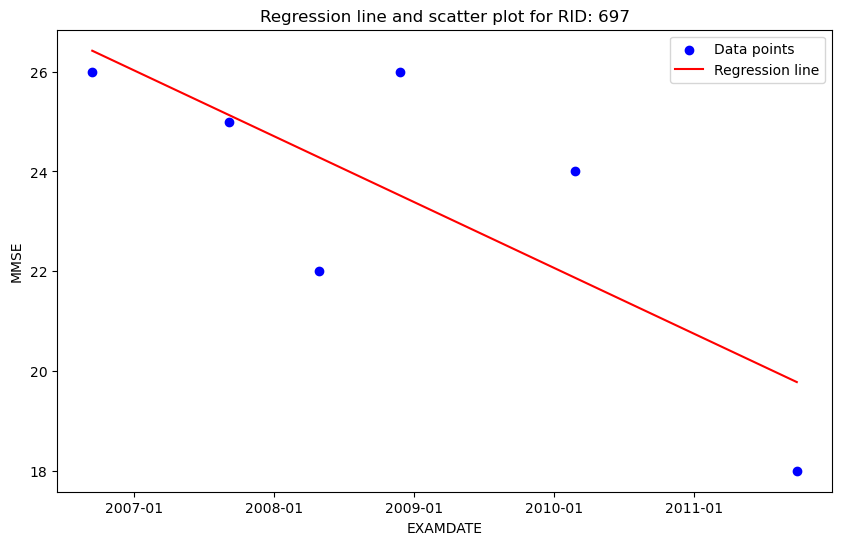

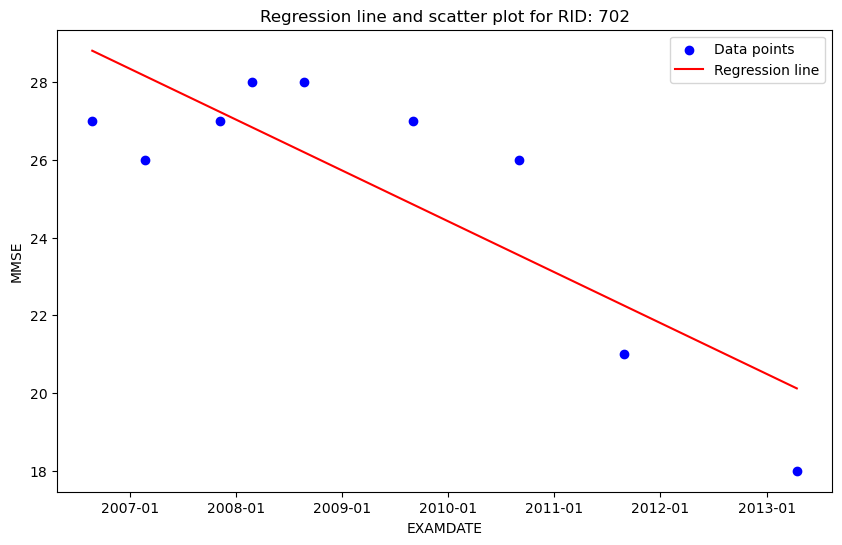

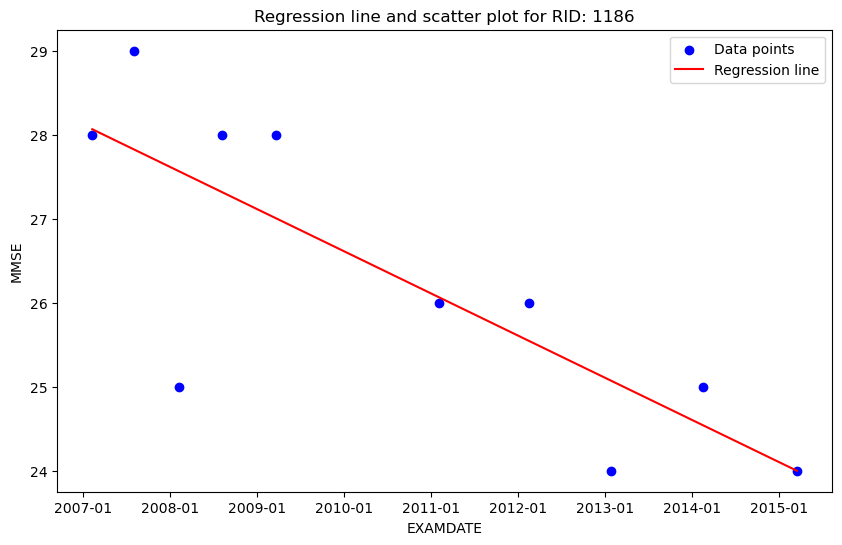

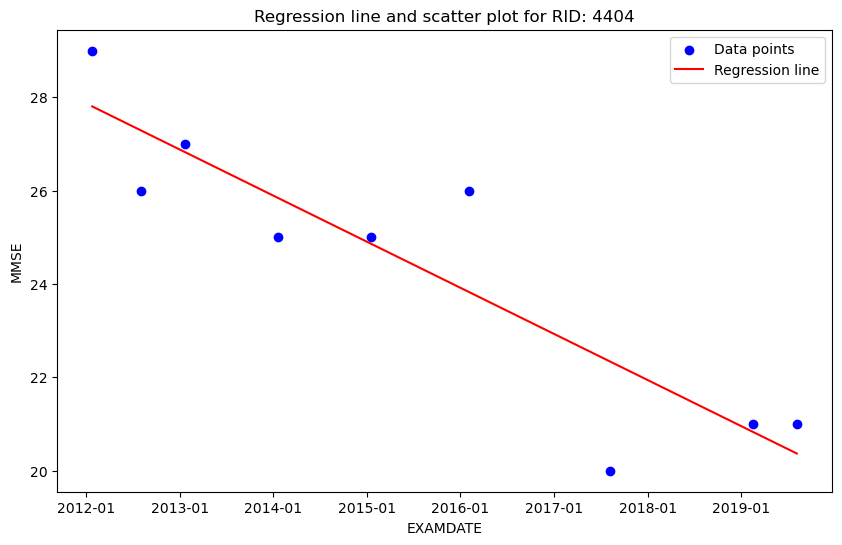

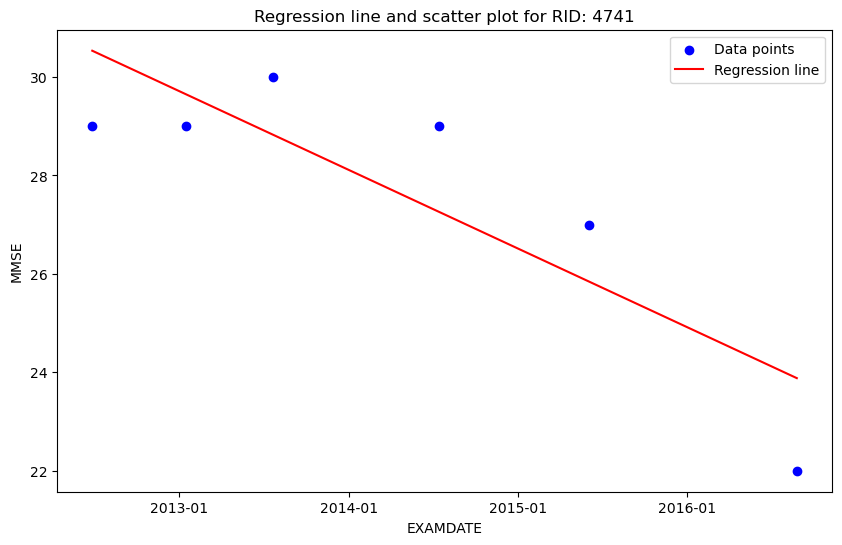

In [6]:
import random
import matplotlib.dates as mdates

# Select a random sample of 3 RIDs
# sample_rids = random.sample(list(unique_rids), 5)
sample_rids = [689, 697, 702, 1186, 4404, 4741]

# For each RID in the random sample, calculate the rate of change and plot the regression
for rid in sample_rids:
    df_rid = df_all[df_all['RID'] == rid].sort_values('EXAMDATE')

    # Convert EXAMDATE to the number of days from the earliest date for regression calculation
    df_rid['EXAMDATE_numeric'] = (df_rid['EXAMDATE'] - df_rid['EXAMDATE'].min()).dt.days

    # Check if the DataFrame has less than two rows for MMSE
    if len(df_rid[df_rid['MMSE'].notnull()]) < 2:
        continue

    # Drop rows with NaN for MMSE
    df_rid_col = df_rid.dropna(subset=['MMSE'])

    # Linear regression
    X = df_rid_col['EXAMDATE_numeric'].values.reshape(-1, 1)  # Features
    y = df_rid_col['MMSE'].values  # Target

    # Also subset original_exam_dates to match the length of y
    original_exam_dates = df_rid_col['EXAMDATE']

    model = LinearRegression()
    model.fit(X, y)

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(original_exam_dates, y, color='blue', label='Data points')
    
    # Regression line
    reg_line = model.predict(X)
    plt.plot(original_exam_dates, reg_line, color='red', label='Regression line')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())

    plt.xlabel('EXAMDATE')
    plt.ylabel('MMSE')
    plt.title(f'Regression line and scatter plot for RID: {rid}')
    plt.legend()
    plt.savefig(f'linear_regre_MMSEroc/RID{rid}.pdf', format='pdf', dpi=300)  # Save the figure to a file
    plt.show()


In [7]:
# group by RID and aggregate
df_agg = df_all.groupby('RID').agg({col: ('mean' if df_all[col].dtype == 'float64' else 'first') 
                                    for col in df_all.columns})

df_agg.reset_index(drop=True, inplace=True)

# merge df_roc to df_agg
if df_agg['RID'].duplicated().any() or df_roc['RID'].duplicated().any():
    print("Duplicate 'RID' values found. Please make sure 'RID' is unique in both dataframes.")
else:
    df_plot = df_agg.merge(df_roc, on='RID')
    
# Apply the round function to each float column
float_cols = df_plot.select_dtypes(include='float64').columns
df_plot[float_cols] = df_plot[float_cols].apply(lambda x: x.round(3))

# Replace diagnosis with numbers
df_plot['DX_bl'] = df_plot['DX_bl'].replace({
    'CN': 0,
    'SMC': 1,
    'EMCI': 2,
    'LMCI': 3,
    'AD': 4
})
df_plot['DX_bl'] = df_plot['DX_bl'].astype(int)

In [8]:
analyze_general_info(df_plot)


Shape of the DataFrame:
 (2416, 27)


,,,,,,,,,,,...,,,,,,,,,,
Column,RID,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,APOE4,FDG,PET-CL,ABETA,...,FDG_roc,PET-CL_roc,ABETA_roc,TAU_roc,PTAU_roc,CDRSB_roc,ADAS11_roc,ADAS13_roc,ADASQ4_roc,MMSE_roc
Dtype,object,datetime64[ns],int32,float64,int64,int64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NumOfNaN,0,0,0,4,0,0,207,799,734,1324,...,1558,1428,1842,1736,1738,298,333,338,332,332


# Model simulation

In [9]:
# Parameters in "Towards the integrative theory of Alzheimer’s disease: linking molecular mechanisms of neurotoxicity, beta-amyloid biomarkers, and the diagnosis"
S = 250
F = 78
Kexc = 0.47

In [10]:
df_plot['Ku_Ka'] = S / df_plot['ABETA'] * 1000 - F - df_plot['PET-CL']

In [11]:
# Calculate the argument of the log function
argument = 1 + df_plot['PET-CL'] / df_plot['Ku_Ka'] / Kexc

# Calculate the logarithm where defined, and handle edge cases
log_arg = argument.apply(lambda x: np.log(x) if x > 0 else np.nan)

# Apply the formula
df_plot['TOX'] = df_plot['Ku_Ka'] * log_arg

In [12]:
# Save the aggregated data as .csv file
df_plot.to_csv('temp_aggregate.csv', index=False)

# Cog_roc v.s. TOX

In [13]:
def plot_ave_in_bins(df, col1, col2):
    df = remove_outliers(df, col1, 5).copy()
    df = remove_outliers(df, col2, 5).copy()
    
    # Create bins based on col1 values
    df['bins'] = pd.cut(df[col1], bins=20)
    
    # Group by the bins and calculate average of col2 values in each bin
    averages = df.groupby('bins')[col2].mean()
    
    # Plot the averages
    plt.figure(figsize=(10, 6))
    plt.plot(averages.index.astype(str), averages.values, marker='o')
    plt.xlabel(col1)
    plt.ylabel('Average of ' + col2)
    plt.title('Average of ' + col2 + ' in bins of ' + col1)
    plt.xticks(rotation=45)
    plt.show()

    # Remove the 'bins' column
    df.drop('bins', axis=1, inplace=True)

def plot_med_in_bins(df, col1, col2):
    df = remove_outliers(df, col1, 5).copy()
    df = remove_outliers(df, col2, 5).copy()
    # Create bins based on col1 values
    df['bins'] = pd.cut(df[col1], bins=15)
    
    # Group by the bins and calculate median of col2 values in each bin
    medians = df.groupby('bins')[col2].median()
    
    # Plot the medians
    plt.figure(figsize=(10, 6))
    plt.plot(medians.index.astype(str), medians.values, marker='o')
    plt.xlabel(col1)
    plt.ylabel('Median of ' + col2)
    plt.title('Median of ' + col2 + ' in bins of ' + col1)
    plt.xticks(rotation=45)
    plt.show()

    # Remove the 'bins' column
    df.drop('bins', axis=1, inplace=True)

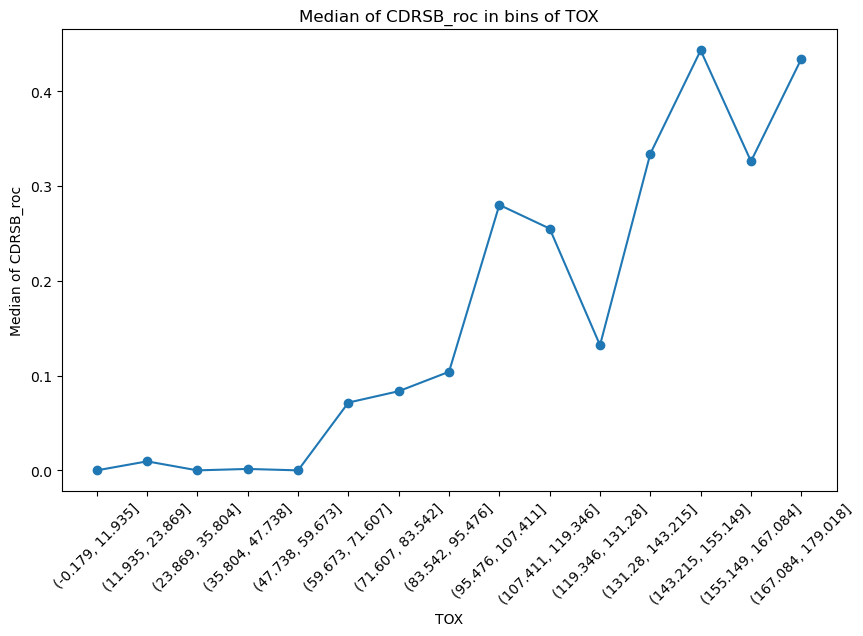

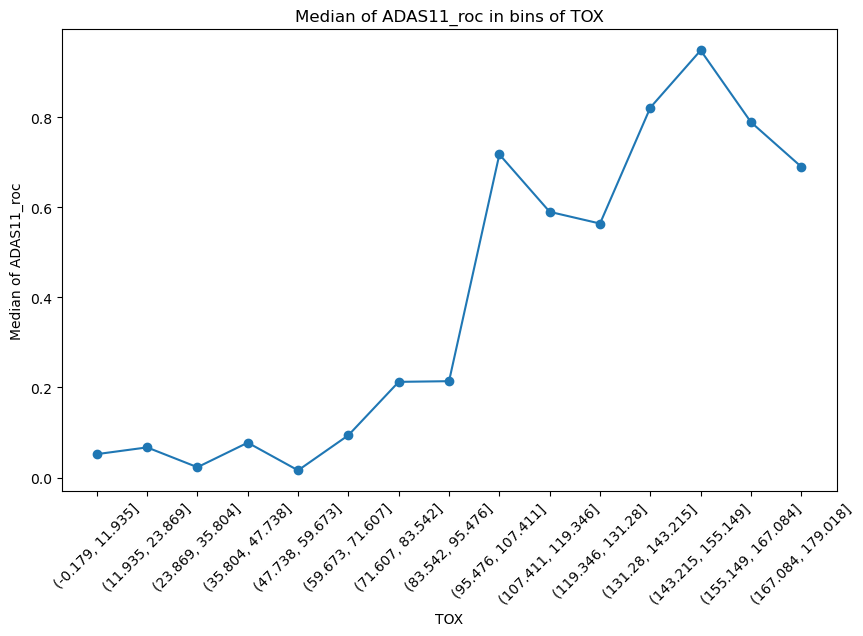

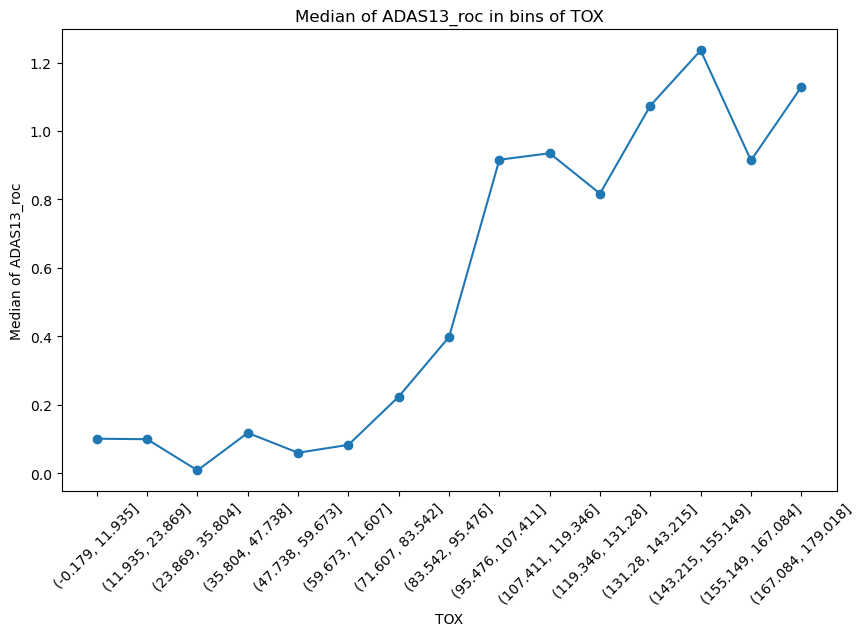

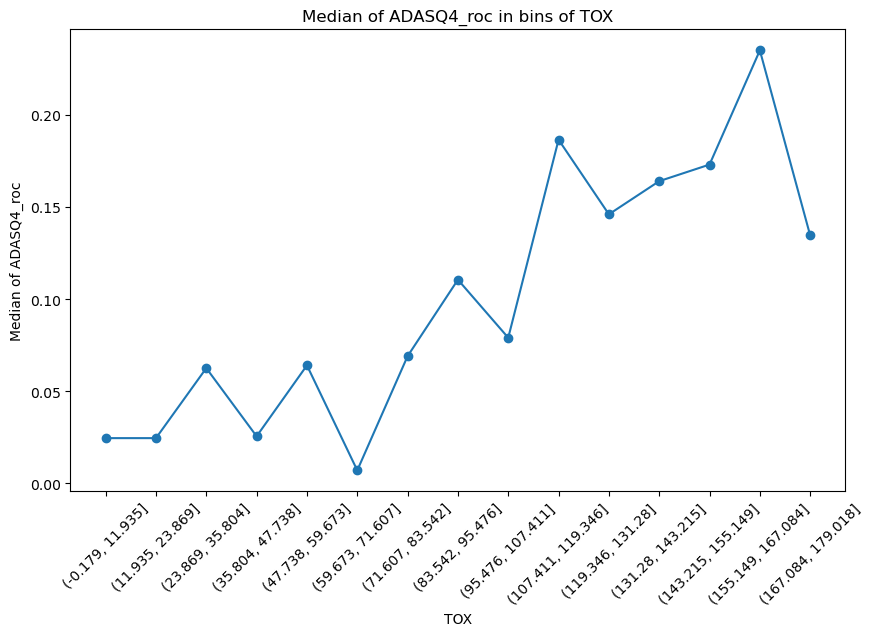

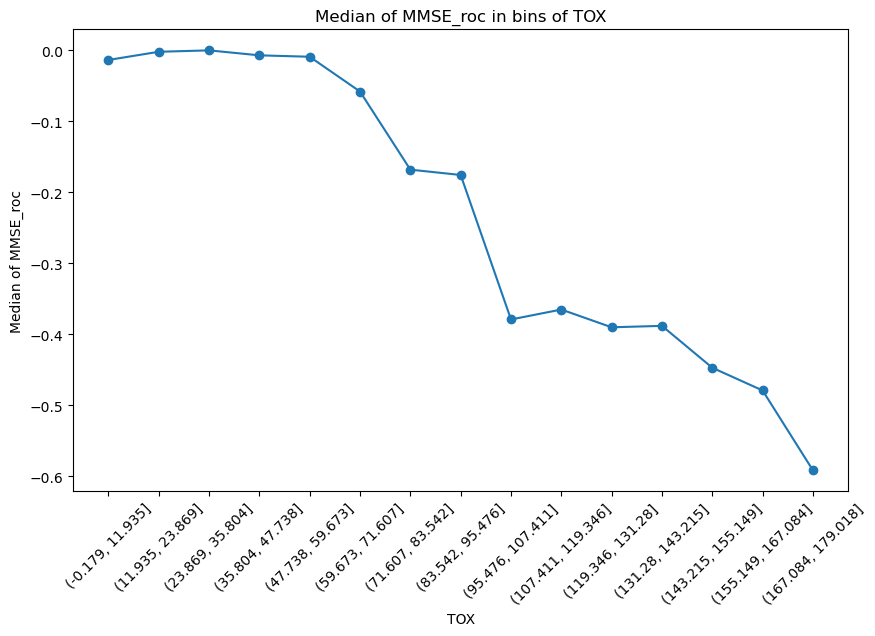

In [14]:
# Get a list of all columns that end with "_roc"
roc_columns = [col for col in df_plot.columns if col.endswith('_roc')]

# Keep only the last five columns
roc_columns = roc_columns[-5:]

# Loop over the roc_columns and plot medians in bins for each one
for col in roc_columns:
    plot_med_in_bins(df_plot, 'TOX', col)

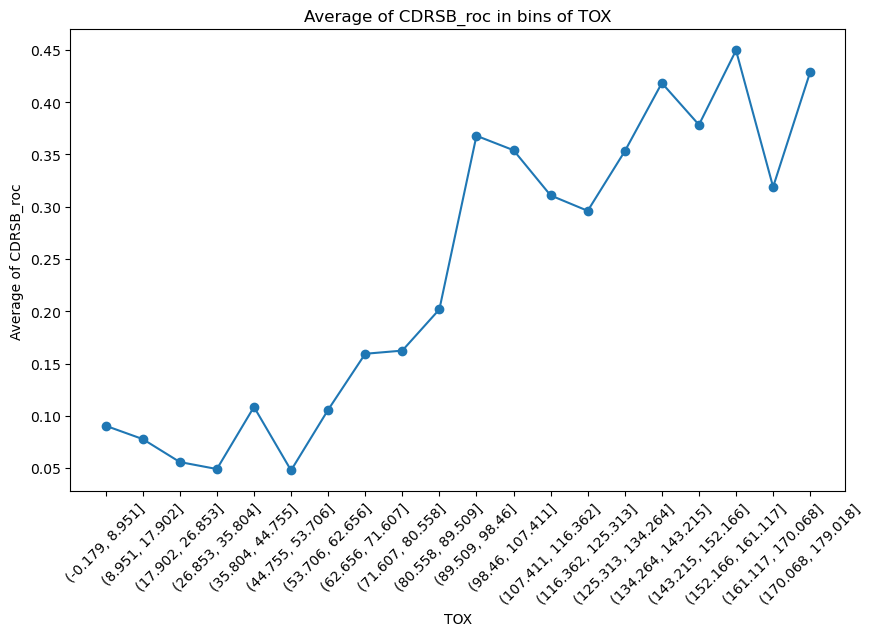

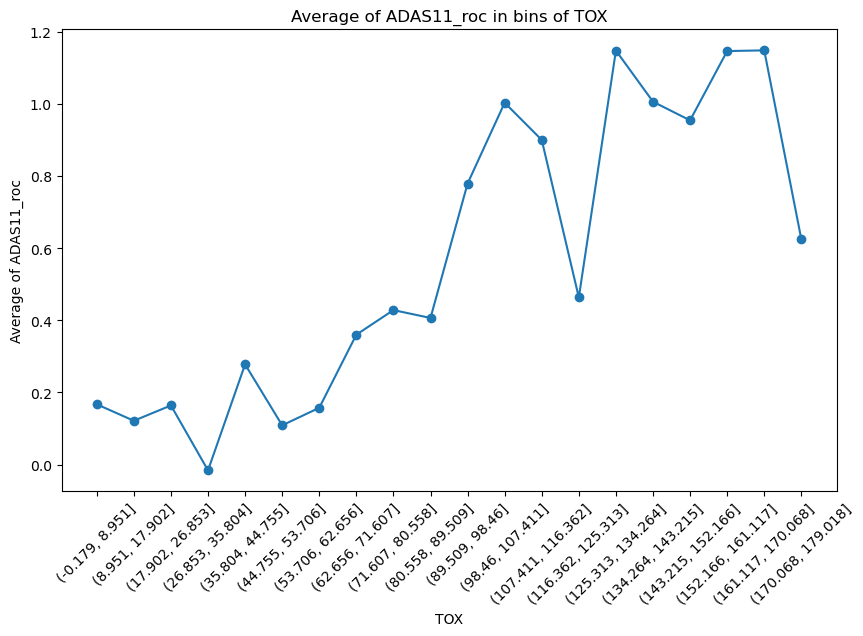

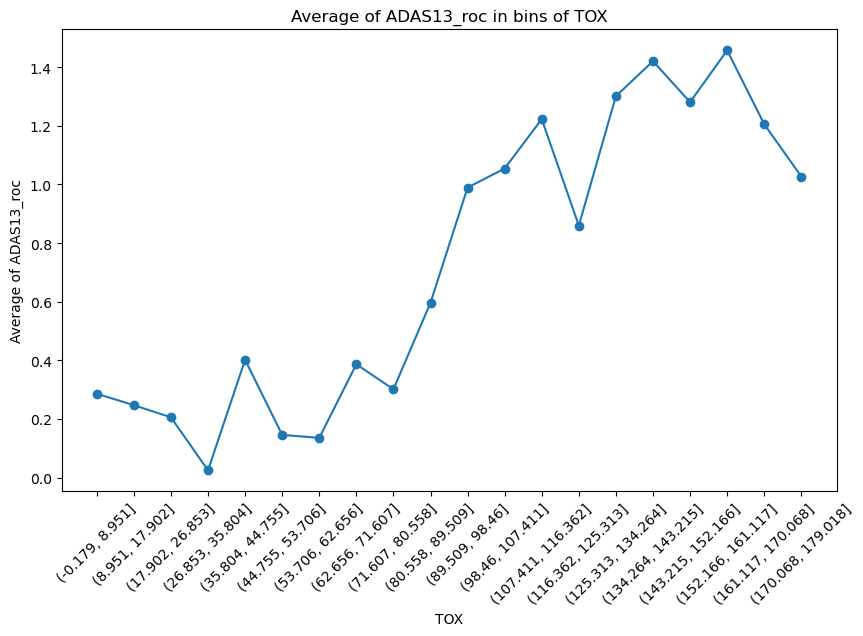

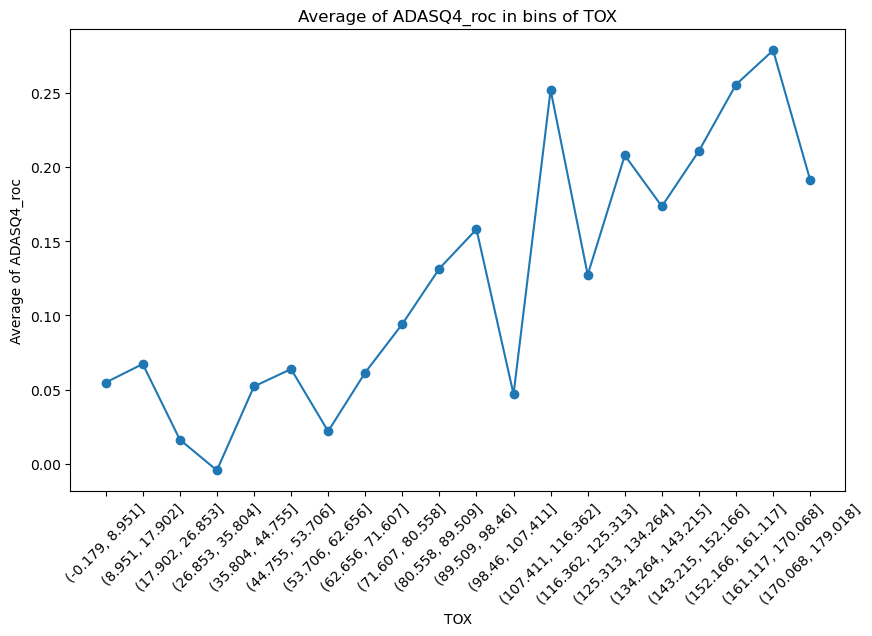

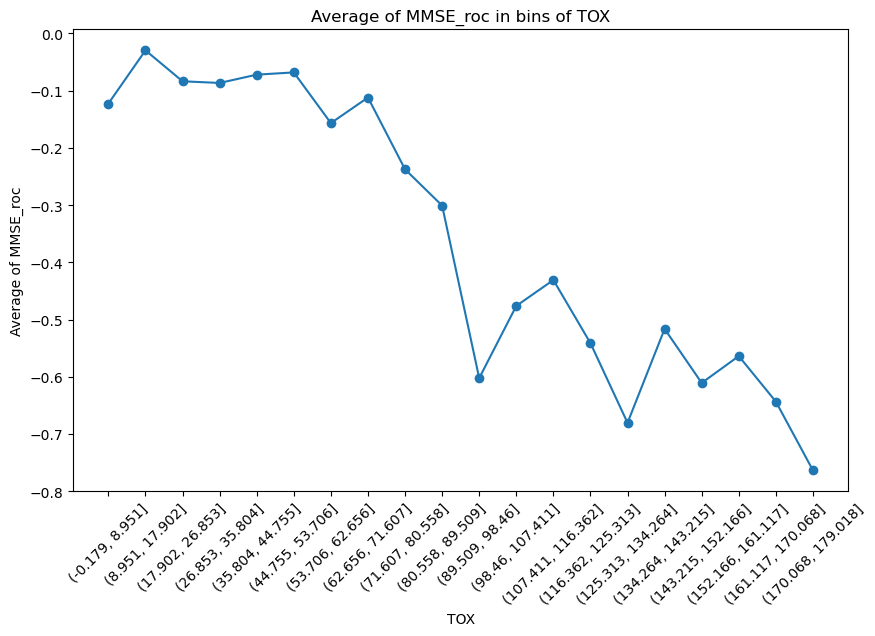

In [15]:
# Loop over the roc_columns and plot medians in bins for each one
for col in roc_columns:
    plot_ave_in_bins(df_plot, 'TOX', col)

In [16]:
def plot_med_quartiles_in_bins(df, col1, col2):
    df = remove_outliers(df, col1, 5).copy()
    df = remove_outliers(df, col2, 5).copy()
    # Create bins based on col1 values
    df['bins'] = pd.cut(df[col1], bins=15)
    
    # Group by the bins and calculate median, 1st and 3rd quartiles of col2 values in each bin
    stats = df.groupby('bins')[col2].agg(['median', 
                                          lambda x: x.quantile(0.25), 
                                          lambda x: x.quantile(0.75)])

    stats.columns = ['median', '1st_quartile', '3rd_quartile']
    
    # Plot the statistics
    plt.figure(figsize=(10, 6))
    plt.plot(stats.index.astype(str), stats['median'].values, marker='o', label='Median')
    plt.plot(stats.index.astype(str), stats['1st_quartile'].values, marker='o', label='1st Quartile')
    plt.plot(stats.index.astype(str), stats['3rd_quartile'].values, marker='o', label='3rd Quartile')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(col2 + ' Statistics in bins of ' + col1)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    # Remove the 'bins' column
    df.drop('bins', axis=1, inplace=True)


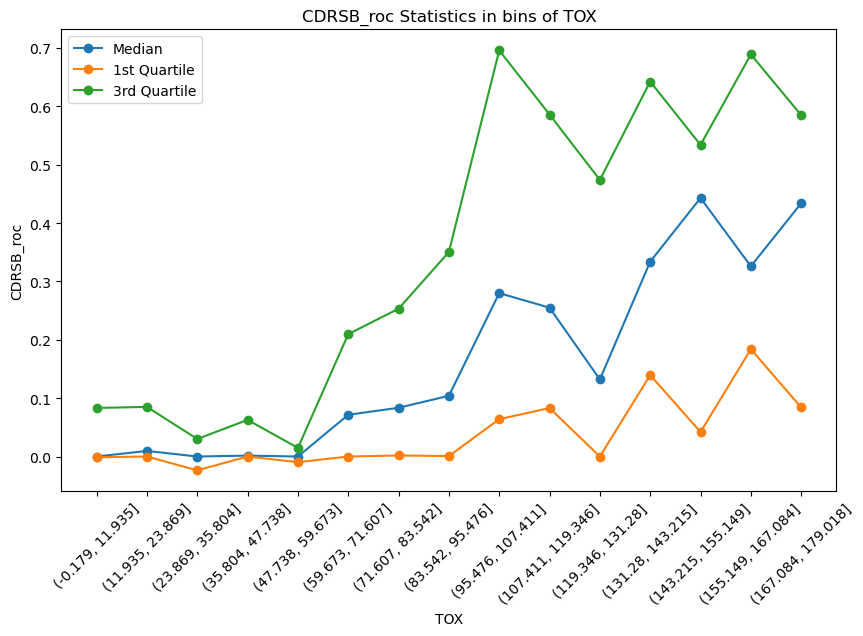

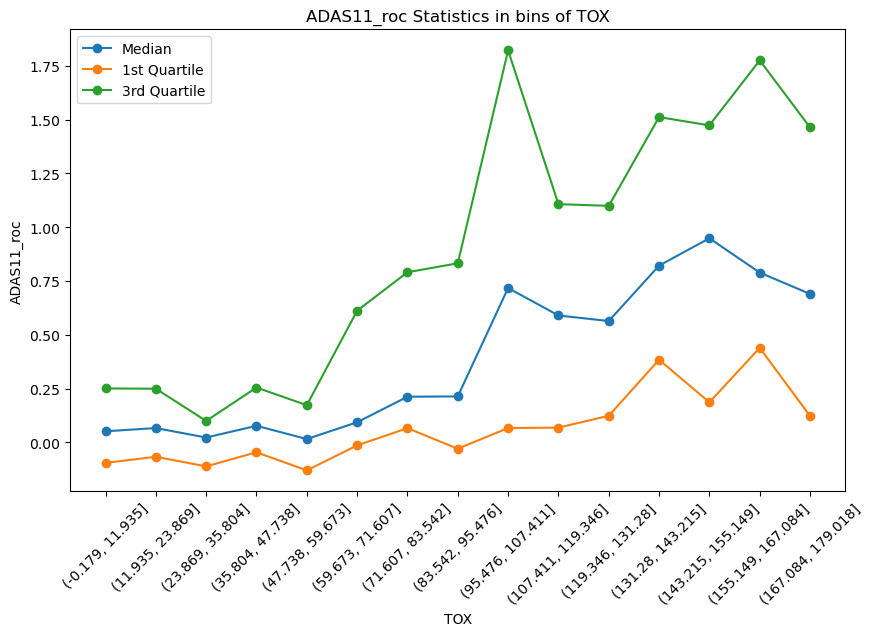

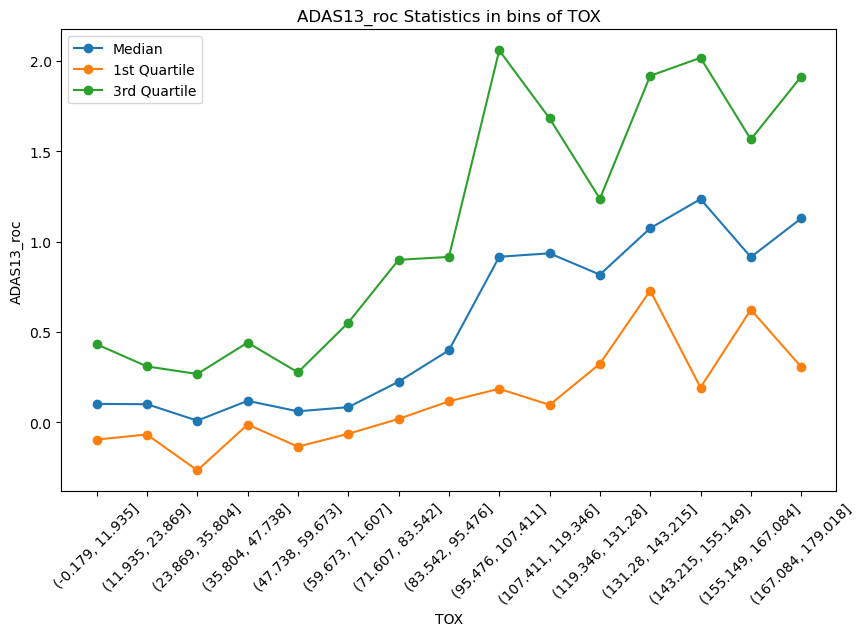

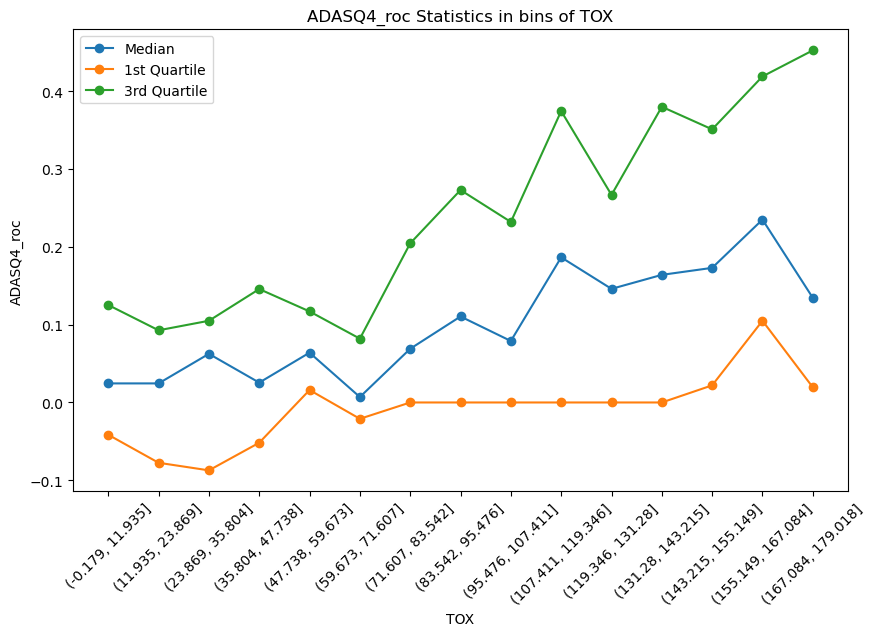

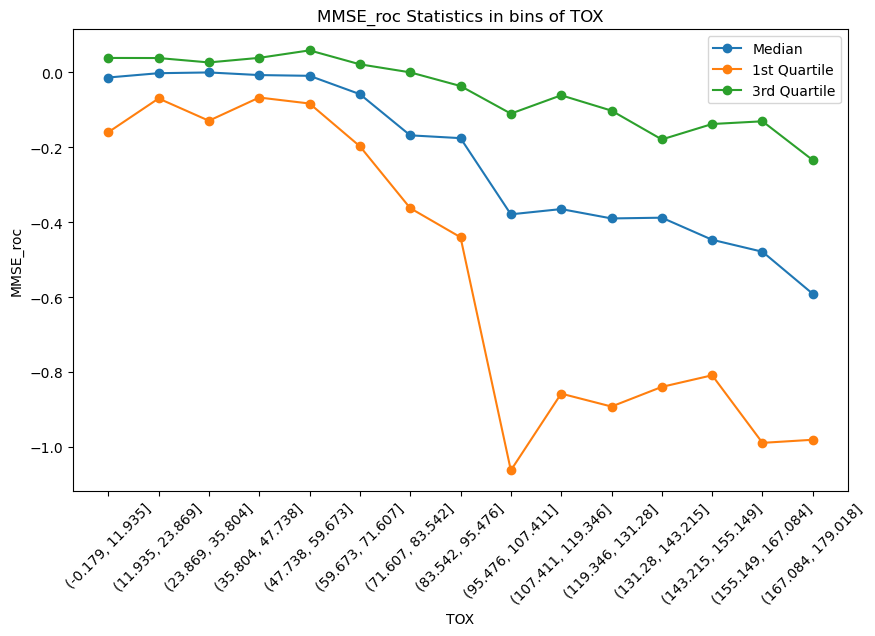

In [17]:
# Get a list of all columns that end with "_roc"
roc_columns = [col for col in df_plot.columns if col.endswith('_roc')]

# Keep only the last five columns
roc_columns = roc_columns[-5:]

# Loop over the roc_columns and plot medians in bins for each one
for col in roc_columns:
    plot_med_quartiles_in_bins(df_plot, 'TOX', col)

In [18]:
# analyze_simple_visual(df_plot)

In [19]:
def add_bin_center(df, col, bins):
    # Create bins
    df['bins'] = pd.cut(df[col], bins=bins)
    
    # Calculate bin centers
    df['bin_center'] = df['bins'].apply(lambda x: x.mid)

    return df
        
def violin_plot(df, category_col, value_col):
    df = remove_outliers(df,value_col,5)
    plt.figure(figsize=(15, 10))
    
    sns.violinplot(x=category_col, y=value_col, data=df)
    
    plt.xlabel(category_col)
    plt.ylabel(value_col)
    plt.title(f'Violin plot of {value_col} grouped by {category_col}')
    plt.show()
    
# df_plot = add_bin_center(df_plot, 'TOX', 15)
# violin_plot(df_plot, 'bin_center', 'MMSE_roc')

In [24]:
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors

def sigmoid(x, L, k, x0):
    return L / (1 + np.exp(-k*(x-x0)))

def calculate_sigmoid_regressions(df, x_col, y_cols):
    """Calculate sigmoid regression parameters for a DataFrame."""
    params = {}
    for y_col in y_cols:
        popt, pcov = curve_fit(sigmoid, x_col, df[y_col].values, p0=[min(df[y_col]), 0.2, np.median(x_col)])
        params[y_col] = popt
    return params

def plot_med_quartiles_w_reg(df, col1, col2):
    df = remove_outliers(df, col1, 5, 95).copy()
    df = remove_outliers(df, col2, 0, 95).copy()
    df['bins'] = pd.cut(df[col1], bins=15)

    # Convert bin labels to bin midpoints
    df['bins_midpoints'] = df['bins'].apply(lambda x: x.mid).astype(float)

    stats = df.groupby('bins_midpoints')[col2].agg([lambda x: x.quantile(0.25), 
                                                    lambda x: x.quantile(0.5),
                                                    lambda x: x.quantile(0.75)])
    stats.columns = ['1st quartile', 'median', '3rd quartile']
    
    # Calculate sigmoid regressions
    params = calculate_sigmoid_regressions(stats, stats.index, stats.columns)
    print(params)

    # Define a dictionary mapping each statistic to a color
    colors = {
        '1st quartile': 'red',
        'median': 'green',
        '3rd quartile': 'blue'
    }

    plt.figure(figsize=(10, 8))
    for col in stats.columns:
        # Plot the scatter lines using the color specified in the dictionary
        plt.plot(stats.index, stats[col].values, marker='o', label=col, color=colors[col])
        
        # Plot the regression lines using a brighter version of the color
        x = np.linspace(min(stats.index), max(stats.index), 100)
        y = sigmoid(x, *params[col])
        brighter_color = mcolors.to_rgba(colors[col], alpha=0.5)  # change alpha to make the color brighter
        plt.plot(x, y, label=f'{col} Regression', color=brighter_color)
        
    plt.xlabel(col1)
    plt.ylabel(col2)
#     plt.title(col2 + ' Statistics in bins of ' + col1)
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig('TOX_vs_MMSE_roc.png', format='png', dpi=300)  # Save the figure to a file
    plt.show()
    df.drop(['bins', 'bins_midpoints'], axis=1, inplace=True)

{'1st quartile': array([-1.35387176e+00,  5.32822357e-02,  9.09427634e+01]), 'median': array([-5.61401256e-01,  6.41969038e-02,  9.35457585e+01]), '3rd quartile': array([-2.06595360e-01,  7.59963054e-02,  1.09840112e+02])}


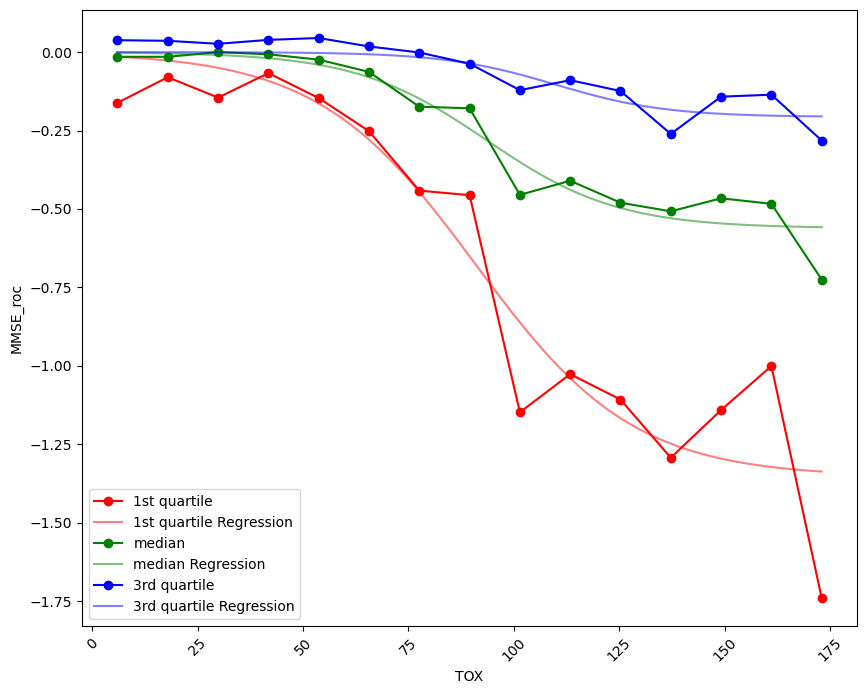

In [25]:
plot_med_quartiles_w_reg(df_plot, 'TOX', 'MMSE_roc')

# Notes for Sprihanjay when making a poster

1. The last figure is the most important one that shows the regression lines for the quantile scatter lines of the data. It uses MMSE (which should be proved as one of the indicative cognitive tests for diagnosis as in your "step 2") rate of change.

2. The parameters $ L, k, x_0 $ for the sigmoid function
$$
f(x) = \frac{L}{1 + e^{-k(x-x_0)}}
$$
after fitting each scatter line are also given above the figure. Plugging in those parameters, you can predict the future MMSE_roc if a TOX value is given. Combining this with your "step 1" when you predict TOX, a full prediction of both TOX and Cognitive Score will be completed.

3. When you explain that figure to someone, please note that this is after a series of data manipulations:
    - MMSE_roc is calculated using linear regression for each patient who has at least two records in the database;
    - The unit of MMSE_roc is per 180 days (which can be changed if you want);
    - When creating the figure, all values TOX (toxicity) for patients are cut into (15) bins with equal distances. And in each bin, the 1st, 2nd (which is the median), and the 3rd quantiles of MMSE_roc are calculated and plotted as the scatter plot.
    - Some outliers are dropped (for a better-looking figure). For MMSE_roc, data points in [0%, 95%] range are kept for the plot and regression; for TOX, data points in [5%, 95%] range.
    
4. Please let me know if you want anything else to be changed, added, or explained, both in content and format.